In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os
import tqdm
import datetime
import time
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler

import loader
import enedis_custom_metric_example as metrics
import data_vis as vis
import data

Using TensorFlow backend.


In [2]:
# LOAD DATA
min_timestamp = 1381694400
x_res, y_res, x_com, y_com, x_labels = loader.load_data(train_file_feat='training_input_qFI2jug.csv',
                                                        train_file_label='training_output_uamzSZW.csv',
                                                        min_timestamp=min_timestamp)
n_res, n_com = x_res.shape[0], x_com.shape[0]


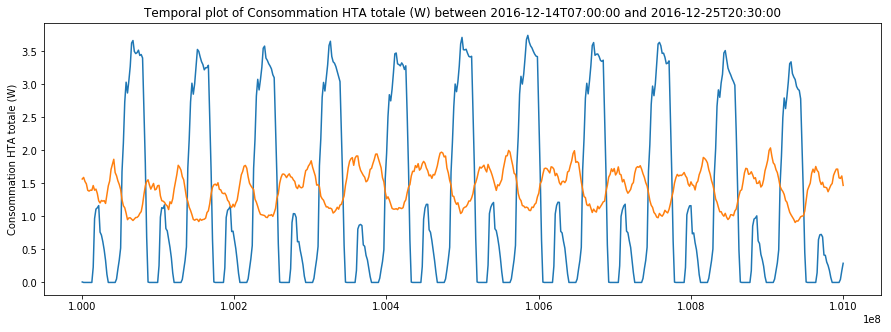

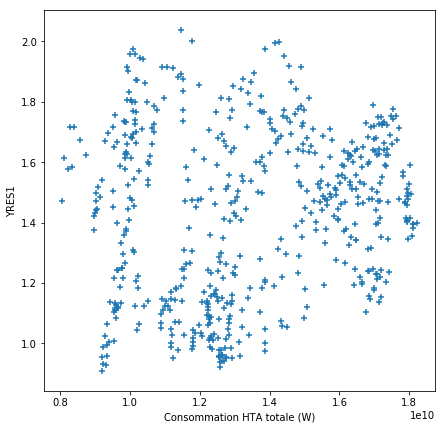

In [3]:
# PLOT DATA
min_t = 1e8
max_t = 1.01e8
x_id = 23
y_id = 1

plt.figure(figsize=(15, 5))
min_id_com = next(x[0] for x in enumerate(x_com[:, 1]) if x[1] >= min_t)
max_id_com = next(x[0] for x in enumerate(x_com[:, 1]) if x[1] >= max_t)
vis.plot_time(x_com[min_id_com:max_id_com, 1], y_com[min_id_com:max_id_com, y_id], label_x=x_labels[x_id])
min_id_res = next(x[0] for x in enumerate(x_res[:, 1]) if x[1] >= min_t)
max_id_res = next(x[0] for x in enumerate(x_res[:, 1]) if x[1] >= max_t)
vis.plot_time(x_res[min_id_res:max_id_res, 1], y_res[min_id_res:max_id_res, y_id], label_x=x_labels[x_id])
plt.show()

plt.figure(figsize=(7, 7))
vis.plot_series(x_res[min_id_res:max_id_res, x_id], y_res[min_id_res:max_id_res, y_id], 
                label_a=x_labels[x_id], label_b='YRES{}'.format(y_id))
plt.show()

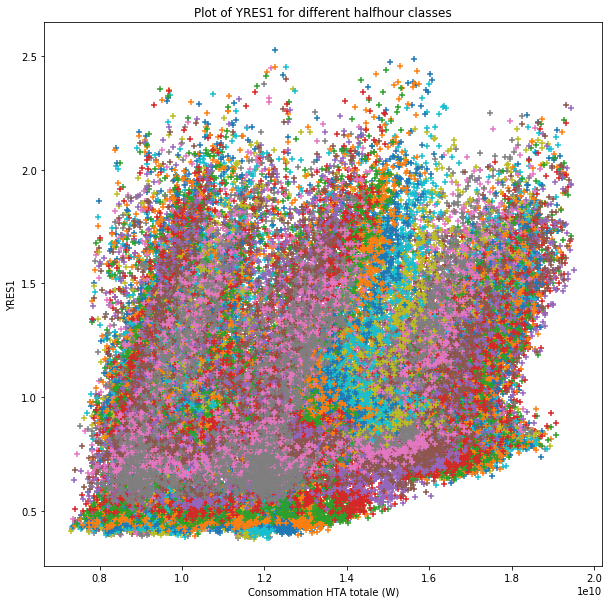

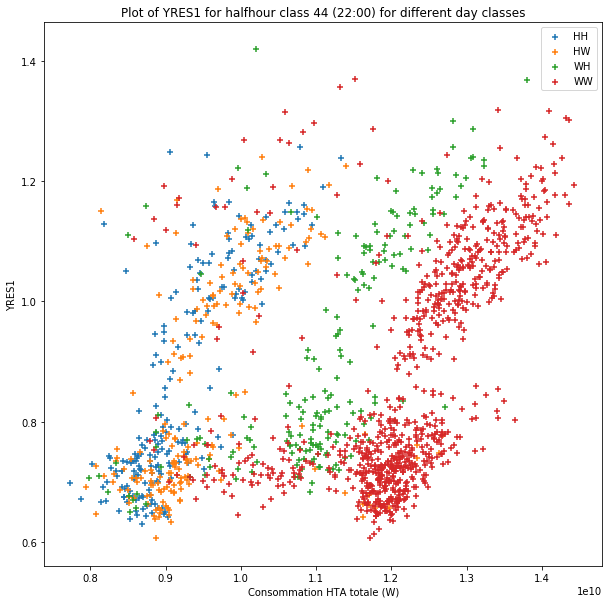

In [4]:
min_id = 0
max_id = n_res

plt.figure(figsize=(10, 10))
for k in range(48):
    vis.plot_series(x_res[min_id+k:max_id:48, x_id], y_res[min_id+k:max_id:48, y_id])
plt.xlabel(x_labels[x_id])
plt.ylabel('YRES{}'.format(y_id))
plt.title('Plot of YRES{} for different halfhour classes'.format(y_id))
plt.show()

plt.figure(figsize=(10, 10))
vis.plot_dayclass(x_res, y_res, x_labels, x_id, y_id, min_id, max_id)
date = datetime.datetime.fromtimestamp(x_res[min_id, 1] + min_timestamp)
h, m = date.hour, date.minute
plt.title('Plot of YRES{} for halfhour class {} ({:02d}:{:02d}) for different day classes'.format(y_id,
                                                                                                  h*2+(m//30),
                                                                                                  h, m))
plt.savefig('HTA_dayclass_{}_{}.png'.format(x_id, y_id))
plt.show()

Proportion of the validation set: 12.3%


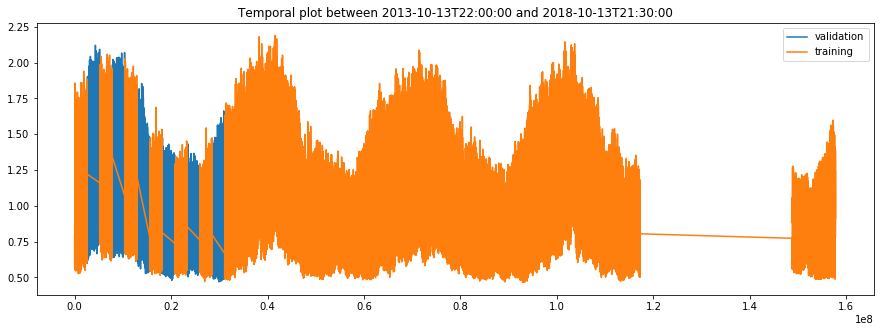

In [5]:
# SEPARATE TRAINING/VALIDATION SETS
is_valid_res = data.separate_x_res(n_res)

plt.figure(figsize=(15, 5))
vis.plot_train_val(x_res, y_res, y_id, is_valid_res, x_labels)
plt.show()

Proportion of the validation set: 10.0%


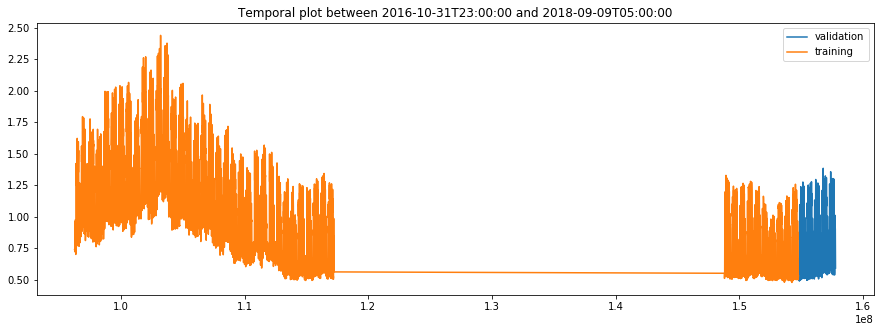

In [6]:
is_valid_com = data.separate_x_com(n_com)

plt.figure(figsize=(15, 5))
vis.plot_train_val(x_com, y_com, y_id, is_valid_com, x_labels)
plt.show()

In [7]:
def create_features(x_train, min_timestamp=1381694400):
    holidays = data.holiday_list()
    day_labels = ['HH', 'HW', 'WH', 'WW']
    n, m = x_train.shape
    features = np.zeros((n, 30), dtype=np.float)
    for i in range(n):
        vec = np.zeros(30, dtype=np.float)
        t = x_train[i, 1]
        dt = datetime.datetime.fromtimestamp(t + min_timestamp)
        weekday = dt.weekday()
        dayclass = data.dayclass(t, holidays)
        vec[day_labels.index(dayclass)] = 1  # dayclass (one hot)
        vec[4+weekday] = 1  # day of the week (one hot)
        beg_year = time.mktime(datetime.datetime.strptime('{}'.format(dt.year), '%Y').timetuple())
        timestamp = t + min_timestamp - beg_year
        vec[11] = timestamp  # time from the beginning of the year
        vec[12:25] = x_train[i][3:16]
        vec[25:28] = x_train[i][18:21]
        vec[28:30] = x_train[i][23:25]
        features[i] = vec
    return features

feats_res = create_features(x_res)
feats_com = create_features(x_com)

In [8]:
def create_sets(features, x, y, is_valid, min_timestamp=1381694400):
    n_feats = features.shape[0]
    halfhour = np.zeros(n_feats, dtype=np.int)
    for i in range(n_feats):
        t = x[i, 1]
        date = datetime.datetime.fromtimestamp(t+min_timestamp)
        h, m = date.hour, date.minute
        n = h * 2 + (m // 30)
        halfhour[i] = n

    id_valid = np.where(is_valid)[0]
    x_valid = features[id_valid]
    y_valid = y[id_valid]
    hh_valid = halfhour[id_valid]
    id_train = np.where([not is_valid[i] for i in range(x.shape[0])])[0]
    x_train = features[id_train]
    y_train = y[id_train]
    hh_train = halfhour[id_train]
    
    return x_train, y_train, hh_train, x_valid, y_valid, hh_valid, id_train, id_valid

x_train_res, y_train_res, hh_train_res, x_valid_res, y_valid_res, hh_valid_res, id_train_res, id_valid_res = create_sets(feats_res, x_res, y_res, is_valid_res)
x_train_com, y_train_com, hh_train_com, x_valid_com, y_valid_com, hh_valid_com, id_train_com, id_valid_com = create_sets(feats_com, x_com, y_com, is_valid_com)

In [9]:
# NORMALIZE DATA
scaler_res = StandardScaler()
scaler_res.fit(x_train_res)
x_train_res_norm = scaler_res.transform(x_train_res)
x_valid_res_norm = scaler_res.transform(x_valid_res)

scaler_com = StandardScaler()
scaler_com.fit(x_train_com)
x_train_com_norm = scaler_com.transform(x_train_com)
x_valid_com_norm = scaler_com.transform(x_valid_com)

In [16]:
# TRAIN MODEL
def train_models(x_train, y_train, hh_train):
    models = [None for i in range(48)]
    seed = 7
    np.random.seed(seed)
    batch_size = 32
    n_epochs = 100
    n_out = y_train.shape[1]
    for i in tqdm.tqdm_notebook(range(48)):
        models[i] = Sequential()
        models[i].add(Dense(32, input_dim=30, kernel_initializer='normal', activation='relu'))
        models[i].add(Dense(16, input_dim=32, kernel_initializer='normal', activation='relu'))
        models[i].add(Dense(n_out, input_dim=16, kernel_initializer='normal'))
        models[i].compile(loss='mean_squared_error', optimizer='adam')
        ind = np.where(hh_train == i)[0]
        x_train_i, y_train_i = x_train[ind], y_train[ind]
        ind = np.arange(x_train_i.shape[0])
        np.random.shuffle(ind)
        x_train_i = x_train_i[ind]
        y_train_i = y_train_i[ind]
        # print('Training model {:2d}/{} with {} samples'.format(i+1, 48, len(ind)))
        models[i].fit(x_train_i, y_train_i, epochs=n_epochs, batch_size=batch_size, verbose=0)
    return models

models_res = train_models(x_train_res_norm, y_train_res, hh_train_res)
models_com = train_models(x_train_com_norm, y_train_com, hh_train_com)

In [ ]:
# SAVE MODEL
# TODO

for i in tqdm.tqdm_notebook(range(48)):
    loader.saveModel(models_res[i], 'models/ckpt_res_{}'.format(i))
    loader.saveModel(models_com[i], 'models/ckpt_com_{}'.format(i))

In [17]:
# PREDICT VALIDATION Y
def predict_multi(models, X_test, hh_test):
    _, n_out = models[0].get_layer(index=-1).output.shape
    Y_test = np.zeros((X_test.shape[0], n_out))
    inds = []
    for i in tqdm.tqdm_notebook(range(48)):
        ind = np.where(hh_test == i)[0]
        # print('Testing model {:2d}/{} on {} samples'.format(i+1, 48, ind.shape[0]))
        X_test_hh = X_test[ind]
        Y_test_hh = models[i].predict(X_test_hh)
        Y_test[ind] = Y_test_hh
    return Y_test

y_valid_pred_res = predict_multi(models_res, x_valid_res_norm, hh_valid_res)
y_valid_pred_com = predict_multi(models_com, x_valid_com_norm, hh_valid_com)

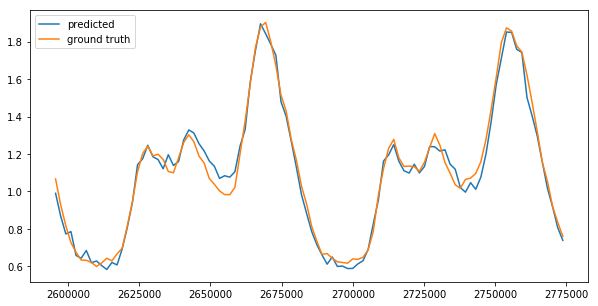

In [18]:
t_valid = x_res[id_valid_res, 1]
t_valid = t_valid[:100]
y_valid_pred = y_valid_pred_res[:100, 0]
y_valid_gt = y_valid_res[:100, 0]
plt.figure(figsize=(10,5))
plt.plot(t_valid, y_valid_pred, label='predicted')
plt.plot(t_valid, y_valid_gt, label='ground truth')
plt.legend(loc='best')
plt.show()

MSE for YRES0: 0.0030
MSE for YRES1: 0.0056
MSE for YRES2: 0.0103
MSE for YRES3: 0.0076
Mean relative error: 0.64%


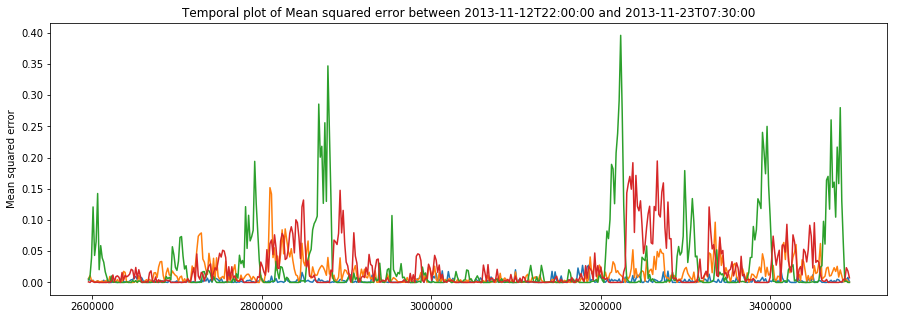

In [34]:
mse = (y_valid_pred_res - y_valid_res) ** 2
mean_mse = np.mean(mse, axis=0)
for i in range(4):
    print('MSE for YRES{}: {:.4f}'.format(i, mean_mse[i]))
print('Mean relative error: {:.2f}%'.format(np.mean(mean_mse / np.mean(y_valid_res, axis=0)) * 100))

plt.figure(figsize=(15, 5))
for i in range(4):
    t = x_res[id_valid_res, 1]
    vis.plot_time(t[:500], mse[:500, i], label_x='Mean squared error')
plt.show()

In [ ]:
test_file_feat = 'testing_input_BcjTmnd.csv',
x_test = []
with open(test_file_feat, 'r') as f:
    for line in f:
        x_test.append(line[:-1])
col_names = x_train[0].split(',')
x_train = [line.split(',') for line in x_train[1:]]
label_names = y_train[0].split(',')
y_train = [line.split(',') for line in y_train[1:]]

# convert data into numpy array
N = len(x_train)
data = np.zeros((N, 25))
labels = ['IDS', 'Timestamp']
for j in range(3, len(col_names)):
    labels.append(col_names[j])

for i in tqdm.tqdm_notebook(range(N), 'Loading data:'):
    row = []
    assert(len(x_train[i]) == 26)
    for j in range(26):
        if j == 1:
            # convert UTC time into translated timestamp
            timestamp = time.mktime(datetime.datetime.strptime(x_train[i][1], '%d/%m/%Y %H:%M').timetuple())
            row.append(timestamp - min_timestamp)
        elif j == 0 or j >= 3:
            row.append(convert(x_train[i][j]))
    data[i] = np.array(row)

In [ ]:
# TODO: loader test data and compute test features
# TODO: generate test output